<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/aburdenko/gcp-jupyter-notebooks/blob/master/vertex-pipelines/kfp-sklearn.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://nbviewer.jupyter.org/github/aburdenko/gcp-jupyter-notebooks/blob/main/vertex-pipelines/kfp-sklearn.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
    <td><a target="_blank"  href="https://colab.sandbox.google.com/github/aburdenko/gcp-jupyter-notebooks/blob/main/vertex-pipelines/kfp-sklearn.ipynb"><img width=26px src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
    <td><a target="_blank"  href="https://console.cloud.google.com/vertex-ai/workbench/list/instances"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/a/a0/Google_Cloud_Workbench.png" /> Run in Google Cloud Vertex Workbench</a></td>
</table>


Based on [Colab Notebooks](https://console.cloud.google.com/marketplace/product/colab-marketplace-image-public/colab) available in GCP Marketplace.

In [21]:
USER = "" # @param {type:"string"} <---CHANGE THESE
BUCKET_NAME = "" # @param {type:"string"} <---CHANGE THESE
GOOGLE_CLOUD_PROJECT = "" # @param {type:"string"} <---CHANGE THESE
REGION = "us-central1" # @param {type:"string"} <---CHANGE THESE

PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, USER)
PIPELINE_ROOT

%env GOOGLE_CLOUD_PROJECT = $GOOGLE_CLOUD_PROJECT


env: GOOGLE_CLOUD_PROJECT=aburdenko-project


In [5]:
import os, sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
nb_path = '/content/notebooks/lib'
os.symlink('/content/drive/My Drive/Colab Notebooks/lib', nb_path)

Mounted at /content/drive


FileExistsError: ignored

In [2]:
if 'google.colab' in sys.modules:
  USER_FLAG = ''
else:
  USER_FLAG = '--user'

In [35]:
!pip3 install --upgrade pip3
!pip3 install --upgrade $USER_FLAG --target=$nb_path kfp --upgrade

ERROR: Could not find a version that satisfies the requirement pip3 (from versions: none)
ERROR: No matching distribution found for pip3
     |████████████████████████████████| 296 kB 5.1 MB/s 
     |████████████████████████████████| 127 kB 48.7 MB/s 
     |████████████████████████████████| 636 kB 43.1 MB/s 
     |████████████████████████████████| 105 kB 52.8 MB/s 
     |████████████████████████████████| 1.6 MB 43.6 MB/s 
     |████████████████████████████████| 61 kB 26 kB/s 
     |████████████████████████████████| 152 kB 55.8 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 97 kB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 87 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 44.4 MB/

In [6]:
sys.path.insert(0,nb_path)

# Authentication and Authorization

In [8]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')

Authenticated


In [11]:
!echo $GOOGLE_CLOUD_PROJECT
!gcloud config set project $GOOGLE_CLOUD_PROJECT

aburdenko-project
Updated property [core/project].


In [ ]:
!gcloud --project $GOOGLE_CLOUD_PROJECT services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com  \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com

Operation "operations/acf.p2-653488387759-9ed9d5fa-b4d9-459f-9d87-0a11c88e0c93" finished successfully.


To take a quick anonymous survey, run:
  $ gcloud survey



In [12]:
from inspect import isdatadescriptor
from typing import NamedTuple

from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import component, OutputPath, InputPath, Output, Input, Dataset, Metrics, Model, Artifact
from kfp.v2.google.client import AIPlatformClient


In [13]:
from google.cloud.bigquery import magics
import google.auth
credentials, project = google.auth.default()

magics.context.credentials = credentials

# Connect to BigQuery

In [14]:
%reload_ext google.cloud.bigquery

Use the storage API for best performance

In [15]:
%%bigquery tax_forms --use_bqstorage_api
SELECT * FROM `bigquery-public-data.irs_990.irs_990_2012`


KeyboardInterrupt: ignored

In [ ]:
tax_forms.head()


,ein,tax_pd,subseccd,unrelbusinccd,initiationfees,grsrcptspublicuse,grsincmembers,grsincother,totcntrbgfts,totprgmrevnue,invstmntinc,txexmptbndsproceeds,royaltsinc,grsrntsreal,grsrntsprsnl,rntlexpnsreal,rntlexpnsprsnl,rntlincreal,rntlincprsnl,netrntlinc,grsalesecur,grsalesothr,cstbasisecur,cstbasisothr,gnlsecur,gnlsothr,netgnls,grsincfndrsng,lessdirfndrsng,netincfndrsng,grsincgaming,lessdirgaming,netincgaming,grsalesinvent,lesscstofgoods,netincsales,miscrevtot11e,totrevenue,compnsatncurrofcr,othrsalwages,payrolltx,profndraising,totfuncexpns,totassetsend,txexmptbndsend,secrdmrtgsend,unsecurednotesend,totliabend,retainedearnend,totnetassetend,nonpfrea,gftgrntsrcvd170,txrevnuelevied170,srvcsval170,grsinc170,grsrcptsrelated170,totgftgrntrcvd509,grsrcptsadmissn509,txrevnuelevied509,srvcsval509,subtotsuppinc509,totsupp509
0,204122653,200412,07,N,0,0,0,0,0,92545,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2075,2578,-503,0,92071,0,0,0,0,92105,23511,0,0,0,0,23511,23511,00,0,0,0,0,0,0,0,0,0,0,0
1,943197474,200512,03,N,0,0,0,0,0,5672,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5672,0,0,0,0,2043,283366,0,0,0,2800,0,280566,13,0,0,0,0,0,0,0,0,0,0,0
2,204774976,200604,03,N,0,0,0,0,0,115339,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,115386,0,0,0,0,116723,4663,0,0,0,6000,0,-1337,07,0,0,0,0,0,0,0,0,0,0,0
3,330227205,200612,03,N,0,0,0,0,4200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4200,0,0,0,0,4000,50,0,0,0,0,0,50,00,0,0,0,0,0,0,0,0,0,0,0
4,364418787,200612,03,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,07,305045,0,0,0,0,0,0,0,0,0,0


In [16]:
@component(
    output_component_file="beans_model_component.yaml"
    , base_image="python:3.9"
    , packages_to_install=["google-cloud-bigquery","pandas","pyarrow"])
def load_table(query: str, project: str) -> str:
    from google.cloud import bigquery    
    import os    
    client = bigquery.Client(project=project)    
    df = client.query(query).to_dataframe()    
    return df.head(100).to_csv()

In [17]:
@component(
    packages_to_install=["google-cloud-bigquery", "pandas", "pyarrow"],
    base_image="python:3.9",
    output_component_file="create_dataset.yaml"
)
def get_dataframe(
    bq_table: str,
    output_data_path: OutputPath("Dataset")
):
    from google.cloud import bigquery
    import pandas as pd

    bqclient = bigquery.Client()
    table = bigquery.TableReference.from_string(
        bq_table
    )
    rows = bqclient.list_rows(
        table
    )
    dataframe = rows.to_dataframe(
        create_bqstorage_client=True,
    )
    dataframe = dataframe.sample(frac=1, random_state=2)
    dataframe.to_csv(output_data_path)

In [18]:
@component(
    packages_to_install=["sklearn", "pandas", "joblib"],
    base_image="python:3.9",
    output_component_file="beans_model_component.yaml",
)
def sklearn_train(
    dataset: Input[Dataset],
    metrics: Output[Metrics],
    model: Output[Model]
):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import roc_curve
    from sklearn.model_selection import train_test_split
    from joblib import dump

    import pandas as pd
    df = pd.read_csv(dataset.path)
    labels = df.pop("unrelbusinccd").tolist()
    data = df.values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(data, labels)

    skmodel = DecisionTreeClassifier()
    skmodel.fit(x_train,y_train)
    score = skmodel.score(x_test,y_test)
    print('accuracy is:',score)

    metrics.log_metric("accuracy",(score * 100.0))
    metrics.log_metric("framework", "Scikit Learn")
    metrics.log_metric("dataset_size", len(df))
    dump(skmodel, model.path + ".joblib")

In [19]:
@component(
    packages_to_install=["google-cloud-aiplatform"],
    base_image="python:3.9",
    output_component_file="beans_deploy_component.yaml",
)
def deploy_model(
    model: Input[Model],
    project: str,
    region: str,
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model]
):
    from google.cloud import aiplatform

    aiplatform.init(project=project, location=region)

    deployed_model = aiplatform.Model.upload(
        display_name="beans-model-pipeline",
        artifact_uri = model.uri.replace("model", ""),
        serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest"
    )
    endpoint = deployed_model.deploy(machine_type="n1-standard-4")

    # Save data to the output params
    vertex_endpoint.uri = endpoint.resource_name
    vertex_model.uri = deployed_model.resource_name



In [22]:
@dsl.pipeline(
    name="sklearn-demo",
    description="A simple sklearn demo",
    pipeline_root=PIPELINE_ROOT,
)
def pipeline(
    bq_table: str = "",
    output_data_path: str = "data.csv",
    project: str = GOOGLE_CLOUD_PROJECT,
    region: str = REGION
):
    dataset_task = get_dataframe(bq_table)

    model_task = sklearn_train(
        dataset_task.output
    )

    deploy_task = deploy_model(
        model=model_task.outputs["model"],
        project=project,
        region=region
    )    

from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="custom_train_pipeline.json"
)


/content/notebooks/lib/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


In [23]:
from datetime import datetime
# from google.cloud import aiplatform
# from google.cloud.aiplatform import pipeline_jobs


api_client = AIPlatformClient(
    project_id=GOOGLE_CLOUD_PROJECT,
    region=REGION,
)

PIPELINE_SPEC_PATH="custom_train_pipeline.json"
PIPELINE_ROOT = 'gs://{}/pipeline_root/{}'.format(BUCKET_NAME, USER)

compiler.Compiler().compile(
   pipeline_func=pipeline, package_path=PIPELINE_SPEC_PATH
)
api_client = AIPlatformClient(project_id=GOOGLE_CLOUD_PROJECT, region=REGION)
response = api_client.create_run_from_job_spec(
 PIPELINE_SPEC_PATH,
 pipeline_root=PIPELINE_ROOT,
 parameter_values={
    "bq_table" : "bigquery-public-data.irs_990.irs_990_2012",
    "output_data_path": "data.csv",
    "project": GOOGLE_CLOUD_PROJECT,
    "region": REGION
 }
)

/content/notebooks/lib/kfp/v2/google/client/client.py:173: FutureWarning: AIPlatformClient will be deprecated in v2.0.0. Please use PipelineJob https://googleapis.dev/python/aiplatform/latest/_modules/google/cloud/aiplatform/pipeline_jobs.html in Vertex SDK. Install the SDK using "pip install google-cloud-aiplatform"
  category=FutureWarning,
/content/notebooks/lib/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


Resultant pipeline should look like the following:

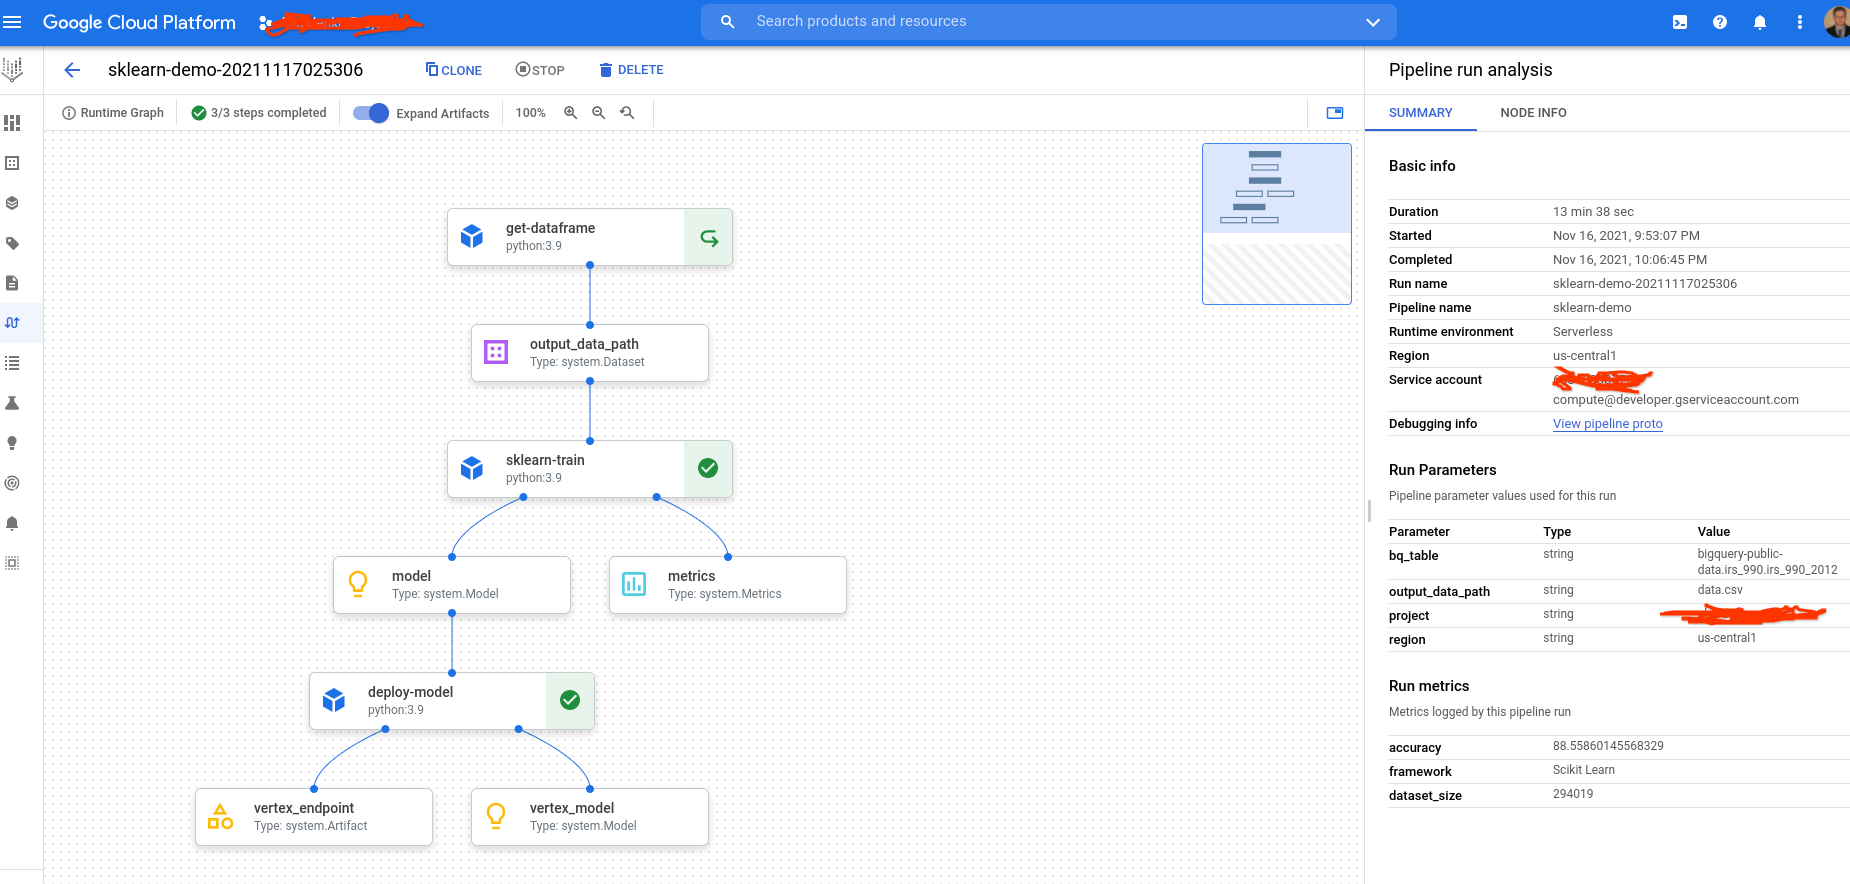

# Create Scikit Learn Model to predict XXX

# Show Model Lineage (Vertex Metadata)